# Analizando un grupo de WhatsApp

Empezamos importando algunas librerías

In [93]:
import re
import numpy as np
import pandas as pd
import regex
import emoji
import collections
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

## Se definen algunas funciones necesarias

Primero, se confirma que la línea de texto inicia con fecha y hora

In [94]:
def startsWithDateAndTime(s):
    pattern = '^([0-9])+/([0-9])+/([0-9])+ ([0-9])+:([0-9])+ -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [95]:
# Probamos la función
x = '01/10/18 19:18 - Señora 5: Claudia, puedes reenviar los paquetes, por favor? 🙏🏼 Aún no estaba en el grupo'
startsWithDateAndTime(x)

True

La segunda función encuentra el nombre del autor según los patrones especificados

In [96]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # Nombre
        '([\w]+[\s]+[\w]+):',              # Nombre y apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+.*):',  # Nombre + 2 apellidos
        '(\+52 1 \d{3} \d{3} \d{4}):',     # Número telefónico (México)
        '([\w]+)[\u263a-\U0001f999]+:',    # Nombre y emoji
        '([\w]+[\s]+[0-9]+):'              # Nombre genérico
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [97]:
# Probamos la función
y = x.split(' - ')
y
print(FindAuthor(y[1]))

True


In [98]:
# Función que separa los datos en columnas
def getDataPoint(line):   
    splitLine = line.split(' - ')                # Divide line en dos partes 
    dateTime = splitLine[0]                      # La primera parte se guarda en dateTime
    date, time = dateTime.split(' ')             # Separa fecha y hora
    message = ' '.join(splitLine[1:])            # Autor + mensaje
    if FindAuthor(message):                      # Si existe autor
        splitMessage = message.split(': ')       # Separa a partir de ': '
        author = splitMessage[0]                 # La primera parte es author 
        message = ' '.join(splitMessage[1:])     # Lo siguiente es el mensaje
    else:
        author = None
    return date, time, author, message

In [99]:
w = ' '.join(y[1:])
z = w.split(': ')
z[1]

'Claudia, puedes reenviar los paquetes, por favor? 🙏🏼 Aún no estaba en el grupo'

In [100]:
parsedData = [] # Lista vacía

# Se carga el archivo
conversationPath = 'Chat de WhatsApp con #EquipoDayci.txt'
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # se omite la primera línea sobre el cifrado de extremo a extremo
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)
   
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%y')

#df.info()

In [101]:
df = df[df.Author.isin(['Arling Vázquez', 'David Fimbres', 'Papol Piñeda', 'lemuel',
       'Celia Beauregard', 'Luis Lopez', 'Karla Vieyra',
       'Fernanda Miranda', 'Jesús Rentería', 'Iván',
       'León Piñeda', 'Dora Luz Enriquez',
       'Paul Rascón', 'MC Gisela Valenzuela',
       'Dayanne Aguirre'])]
df.Author = df.Author.str.replace(r'\s.*', '')
df.head()

,Date,Time,Author,Message
2,2016-07-20,16:03,Arling,Arling Salió del grupo... 👀
3,2016-07-20,16:03,David,Son muy borrachos lo de datos
4,2016-07-20,16:03,David,Por eso se sale
5,2016-07-20,16:03,David,Jajajaj
6,2016-07-20,16:03,David,Malas influencias


In [102]:
# Eliminar mensajes generados por WhatsApp (Author = NULO)
df = df.dropna()
df.info()

# Cambiar nombre y mensaje a minúsculas
df.Message = df.Message.str.lower()
df.Author = df.Author.str.lower()

# Modificar con expresión regular las onomatopeyas de risa
df.Message = df.Message.str.replace(r'(a|j)?(ja)+(a|j)?', 'jaja')
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22777 entries, 2 to 27490
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     22777 non-null  datetime64[ns]
 1   Time     22777 non-null  object        
 2   Author   22777 non-null  object        
 3   Message  22777 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 889.7+ KB


,Date,Time,Author,Message
2,2016-07-20,16:03,arling,arling salió del grupo... 👀
3,2016-07-20,16:03,david,son muy borrachos lo de datos
4,2016-07-20,16:03,david,por eso se sale
5,2016-07-20,16:03,david,jaja
6,2016-07-20,16:03,david,malas influencias


## Anonimizamos los datos

In [103]:
# La lista de personajes de Brooklyn 99
b99 = pd.read_csv("brooklyn99.csv")

# Obtiene nombres y aliases
nombres = list(df.Author.unique())
aliases = list(b99.Label.sample(len(nombres)))

# Remplaza en la columna A nombres por aliases por entrada completa
df.Author.replace(nombres, aliases, inplace=True)

#Remplaza en la columna B en cada entrada en forma de string (por partes)
for (nombre, alias) in zip(nombres, aliases):
    df.Message = df.Message.str.replace(nombre, alias)

df.head()

,Date,Time,Author,Message
2,2016-07-20,16:03,Jake,Jake salió del grupo... 👀
3,2016-07-20,16:03,Terry,son muy borrachos lo de datos
4,2016-07-20,16:03,Terry,por eso se sale
5,2016-07-20,16:03,Terry,jaja
6,2016-07-20,16:03,Terry,malas influencias


In [112]:
print(nombres)
print(aliases)

['arling', 'david', 'papol', 'lemuel', 'celia', 'luis', 'karla', 'fernanda', 'jesús', 'iván', 'león', 'dora', 'paul', 'dayanne']
['Jake', 'Terry', 'Madeline Wuntch', 'El Buitre', 'Charles', 'Pimiento', 'Sharon', 'Kevin', 'Hitchcock', 'Amy', 'Gina', 'Scully', 'Raymond Hold', 'Rosa']


In [105]:
emoji_regexp = u'[\U00002600-\U000026FF]|[\U00002700-\U000027BF]|[\U0001f300-\U0001f5fF]|[\U0001f600-\U0001f64F]|' \
               u'[\U0001f680-\U0001f6FF]'
lista_emoji = re.findall(emoji_regexp, x, re.UNICODE)
print(lista_emoji)
len(lista_emoji)


['🙏', '🏼']


2

In [110]:
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [111]:
print(x)
#df.iloc[3, 3]
#re.findall(r'\X', df.iloc[:, 3])
re.findall(emoji_regexp, x)
split_count(x)

01/10/18 19:18 - Señora 5: Claudia, puedes reenviar los paquetes, por favor? 🙏🏼 Aún no estaba en el grupo


['🙏🏼']

In [108]:
total_messages = df.shape[0] 
media_messages = df[df['Message'] == '<multimedia omitido>'].shape[0]
df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

In [116]:
print('Mensajes enviados: ', total_messages)
print('Mensajes multimedia: ', media_messages)
print('Emojis: ', emojis)
print('Links enviados: ', links)   

Mensajes enviados:  22777
Mensajes multimedia:  4327
Emojis:  7840
Links enviados:  326


In [121]:
# Crea una lista de autores sin repetición
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtra mensajes de un autor
  req_df= messages_df[messages_df["Author"] == l[i]]
  print(f'Estados de {l[i]} -')
  print('Mensajes enviados ', req_df.shape[0])
  words_per_message = ((np.sum(req_df['Word_Count']))/req_df.shape[0]).round(2)
  print('Palabras por mensaje ', words_per_message)
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Multimedia enviados ', media)
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis enviados', emojis)
  links = sum(req_df["urlcount"])   
  print('Links enviados', links)   
  print()

Estados de Jake -
Mensajes enviados  1125
Palabras por mensaje  5.45
Multimedia enviados  52
Emojis enviados 684
Links enviados 15

Estados de Terry -
Mensajes enviados  3242
Palabras por mensaje  5.23
Multimedia enviados  1233
Emojis enviados 1381
Links enviados 70

Estados de Madeline Wuntch -
Mensajes enviados  5081
Palabras por mensaje  4.16
Multimedia enviados  478
Emojis enviados 529
Links enviados 110

Estados de El Buitre -
Mensajes enviados  1336
Palabras por mensaje  5.82
Multimedia enviados  433
Emojis enviados 1114
Links enviados 25

Estados de Charles -
Mensajes enviados  650
Palabras por mensaje  4.35
Multimedia enviados  73
Emojis enviados 627
Links enviados 7

Estados de Pimiento -
Mensajes enviados  2612
Palabras por mensaje  7.28
Multimedia enviados  904
Emojis enviados 880
Links enviados 42

Estados de Sharon -
Mensajes enviados  1530
Palabras por mensaje  3.78
Multimedia enviados  304
Emojis enviados 1502
Links enviados 5

Estados de Kevin -
Mensajes enviados  1164


In [ ]:
# Palabras enviadas en total
text = " ".join(review for review in messages_df.Message)
print ("El total de palabras en todos los mensajes es: {}.".format(len(text)))

In [183]:
# Variedad de emojis enviados
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print("En total, se enviaron ", total_emojis, " emojis diferentes.")

En total, se enviaron  410  emojis diferentes.
El total de palabras en todos los mensajes es: 570755.


In [184]:
# Frecuencia observada de emojis (top 15)
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(collections.Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df.head(15)

,emoji,count
0,😂,1258
1,🤣,949
2,👀,217
3,❤,165
4,🎉,162
5,👍,161
6,🙈,151
7,😱,148
8,🤔,144
9,👍🏻,139


## Gráficos

In [82]:
# Gráfica de pastel - emojis
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [83]:
# Gráfica de pastel - emojis por autor
l = messages_df.Author.unique()

for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(collections.Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Arling Vázquez


Emoji Distribution for David Fimbres


Emoji Distribution for Papol Piñeda


Emoji Distribution for lemuel


Emoji Distribution for Celia Beauregard


Emoji Distribution for Luis Lopez


Emoji Distribution for Karla Vieyra


Emoji Distribution for Fernanda Miranda


Emoji Distribution for Jesús Rentería


Emoji Distribution for Iván


Emoji Distribution for Mabel Aguirre


Emoji Distribution for Fernando Arvizu


Emoji Distribution for León Piñeda


Emoji Distribution for Dora Luz Enriquez


Emoji Distribution for Gisselle Mange


Emoji Distribution for Paul Rascón


Emoji Distribution for MC Gisela Valenzuela


Emoji Distribution for Dayanne Aguirre


There are 571745 words in all the messages.


In [55]:
import nltk
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('spanish')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arling/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
stopwords = set(STOPWORDS)
stopwords.update(set(["si", "multimedia", "omitido",
    "ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le"]))


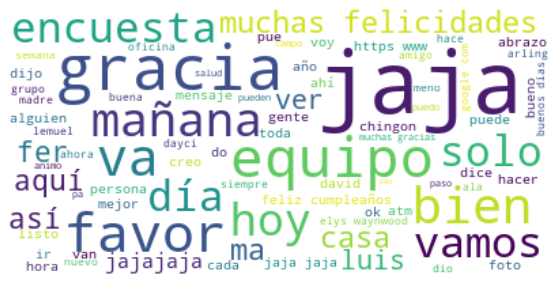

In [57]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",
                     max_words = 80).generate(text)

# Display the generated image:
# the matplotlib way:  
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear', vmin=12, vmax=20)
plt.axis("off")
plt.show()


In [58]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount", title='Number of Messages as time moves on.') 
fig.update_xaxes(nticks=20)
fig.show()

Text(0, 0.5, 'Date')

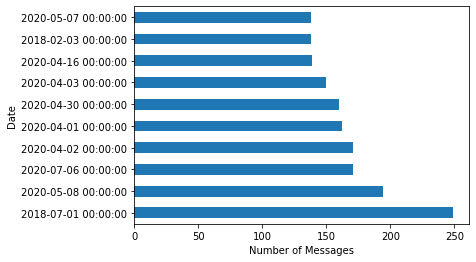

In [59]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

In [64]:
def dayofweek(i):
  l = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(dayofweek)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,4000]
    )),
  showlegend=False
)
fig.show()

Text(0, 0.5, 'Time')

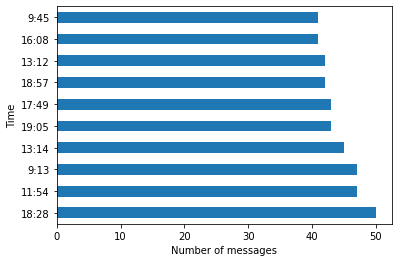

In [66]:
messages_df['Time'].value_counts().head(10).plot.barh() 
plt.xlabel('Number of messages')
plt.ylabel('Time')